In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import platform
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

In [2]:
print(f'Pytorch version: {torch.__version__}')
print(f'cuda version: {torch.version.cuda}')
print(f'Python version: {platform.python_version()}')

Pytorch version: 2.4.1
cuda version: None
Python version: 3.10.14


In [3]:
# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Load data and normalize

### Normalization


In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

Normalization adjusts the values of the image tensors using the following formula:

 $X_{normalized}$ = $\frac{X - \mu}{\sigma}$


where:

- X is the value of each pixel in the image.
- is the mean of the pixel values, which in this case is 0.5.
- σ is the standard deviation, also 0.5 in this case.

shifts the values to the range [-1, 1].

### Data splitting and more

In [5]:
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
print("Training size:", len(train_dataset))
print("Test size:", len(test_dataset))

Training size: 60000
Test size: 10000


In [7]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

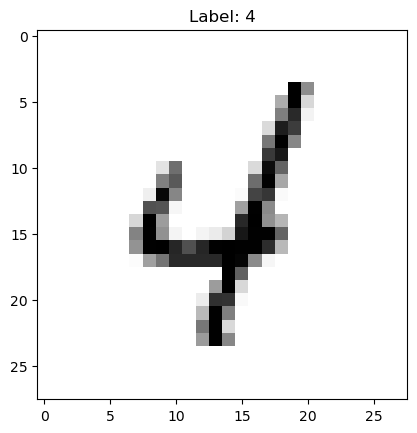

In [8]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')
plt.title(f"Label: {labels[0].item()}")
plt.show()

In [9]:
images[0].shape

torch.Size([1, 28, 28])

In [10]:
images[0].unique()

tensor([-1.0000, -0.9765, -0.9686, -0.9608, -0.9529, -0.9294, -0.9137, -0.9059,
        -0.8745, -0.8510, -0.8431, -0.7804, -0.7098, -0.7020, -0.6941, -0.6863,
        -0.6627, -0.4510, -0.4196, -0.3490, -0.3098, -0.2549, -0.2235, -0.2157,
        -0.1608, -0.1373, -0.1294, -0.1059, -0.0902, -0.0824, -0.0588, -0.0510,
        -0.0353, -0.0039,  0.0039,  0.0667,  0.0902,  0.1373,  0.1451,  0.2157,
         0.2392,  0.2941,  0.3412,  0.3569,  0.3725,  0.4667,  0.5294,  0.5451,
         0.5765,  0.6000,  0.6235,  0.6471,  0.6706,  0.6863,  0.7020,  0.7725,
         0.8118,  0.8196,  0.9059,  0.9294,  0.9608,  0.9843,  0.9922,  1.0000])

# $LeNet$-$5$ <span style="color:MediumSeaGreen">_Architecture_</span>


<img title="a title" alt="Alt text" src="images/architecture_LeNet-5.png">


LeNet-5 consists of seven layers (not counting input) with three main types of layers: convolutional layers, subsampling (pooling) layers, and fully connected layers. The model takes a 32x32 grayscale input image and produces an output with 10 classes, corresponding to the digits 0 through 9. Here’s the sequential breakdown of each layer:



### <span style="color:DodgerBlue">1. Input layer</span>
The input is a 32x32 pixel image, but in the MNIST data the images are 28x28. We need to resize the images using the normalization shown before and store it as a tensor.

### <span style="color:DodgerBlue">2. C1: First Convolutional Layer</span>

This layer performs convolution using 6 filters of size 5x5 across the input image, producing six 28x28 feature maps. Each filter extracts different local features like edges and corners.

- **Feature Maps:** 6

- **Connections:** Each unit is fully connected to C5
- **Stride:** 1 
- **Padding:** None (the layer is a "valid" convolution, reducing the image size)
- **Output Size:** 28 x 28 x 6 (since the input is 32x32 and applying a 5x5 filter reduces each dimension by 4, yielding 28x28)
- **Activation:** Sigmoid (in the original architecture, in modern implementations often use ReLU)
- **Trainable parameters:** 156 (weight + bias = 5 x 5 x 1 x 6 + 6)
- **Connections:** 122,304 (28 x 28 x 156)


### <span style="color:DodgerBlue">3. S2: First Subsampling (Pooling) Layer</span>

This layer reduces the spatial dimensions of each of the 6 feature maps from 28x28 to 14x14 using 2x2 average pooling. Pooling helps reduce the computational load, extract dominant features, and introduces some degree of translation invariance.

- **Feature Maps:** 6

- **Filter Size:** 2 x 2
- **Padding:** 0
- **Stride:** 2
- **Output Size:** 14 x 14 x 6
- **Activation:** None. Performs subsampling directly on the input.
- **Trainable parameters:** 12 ((coefficient + bias) x filters = (1 + 1) x 6)
- **Conections:** 5,880 (14 x 14 x 30)


### <span style="color:DodgerBlue">4. C3: Second Convolutional Layer</span>

This layer applies 16 filters of size 5x5. Each of these filters is connected to all six feature maps from the previous layer in a complex connectivity pattern (Table I shows the set of S2 feature maps). This design choice was meant to increase the variety of patterns learned by the network.

<img title="a title" alt="Alt text" src="images/S2.png" width=600>

- **Feature Maps:** 16

- **Filter Size:** 5 x 5
- **Padding:** 0
- **Stride:** 1
- **Output Size:** 10 x 10 x 16
- **Activation:** Sigmoid
- **Trainable parameters:** 1,516 (weight + bias = (5 x 5 x 6 x 10) + 16)
- **Conections:** 151,600 (10 x 10 x 1516)


### <span style="color:DodgerBlue">5. S4: Second Subsampling (Pooling) Layer</span>

Similar to S2, this layer reduces the spatial dimensions of the 16 feature maps from 10x10 to 5x5 using 2x2 average pooling.

- **Feature Maps:** 16

- **Filter Size:** 2 x 2
- **Padding:** 0
- **Stride:** 2
- **Output Size:** 5 x 5 x 16
- **Activation:** None
- **Trainable parameters:** 12 ((coefficient + bias) x filters = (1 + 1) x 16)
- **Conections:** 2,000 (5 x 5 x 80)


### <span style="color:DodgerBlue">6. C5: Third Convolutional Layer (Fully Connected Convolutional Layer)</span>

This layer is technically a convolutional layer but functions as a fully connected layer since the filter size matches the input dimension (5x5). The 120 filters create a single output for each, resulting in a 1x1x120 output.

- **Feature Maps:** 120

- **Filter Size:** 5 x 5
- **Padding:** 0
- **Stride:** 1
- **Output Size:** 1 x 1 x 120 (since the input is 5x5, applying a 5x5 filter results in a 1x1 output)
- **Activation:** Sigmoid
- **Trainable parameters:** 48,120 (weight + bias = (400 x 120) + 120)
- **Conections:** 48,120

### <span style="color:DodgerBlue">7. F6: Fully Connected Layer</span>

his layer has 84 neurons, each fully connected to the 120-element input vector. This part of the network is similar to a traditional multi-layer perceptron, serving to combine the extracted features from previous layers to make predictions.

- **Units:** 84

- **Output Size:** 1 x 1 x 120 (since the input is 5x5, applying a 5x5 filter results in a 1x1 output)
- **Activation:** Uses a scaled hyperbolic tangent function $f(a) = A 
*tanh(Sa)$
- **Trainable parameters:** 10,164 (weight + bias = (120 x 84) + 84)
- **Conections:** 10,164


### <span style="color:DodgerBlue">8. Output Layer</span>

he final layer has 10 neurons, each corresponding to one of the digit classes (0-9). This layer produces the network's output, a probability distribution over the 10 classes, using the softmax function.

 **Units:** 10

- **Output Size:** 1 x 1 x 120 (since the input is 5x5, applying a 5x5 filter results in a 1x1 output)
- **Activation:**  Euclidean Radial Basis Function units (RBF)

Each RBF unit $y_i$ is computed as follow: 

$y_i = \sum_{j} (x_j - w_{ij})^2$  

Modern versions use Softmax


In [11]:
# LeNet-5 (original architecture)
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 16*4*4)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

# Architecture 2: LeNet-5 with one convolutional layer removed
class LeNet5_OneConv(nn.Module):
    def __init__(self):
        super(LeNet5_OneConv, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.fc1 = nn.Linear(6*12*12, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 6*12*12)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

# Architecture 3: LeNet-5 with an additional convolutional layer
class LeNet5_ExtraConv(nn.Module):
    def __init__(self):
        super(LeNet5_ExtraConv, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3)
        
        # Update the input size for the first fully connected layer
        self.fc1 = nn.Linear(32*1*1, 120)  # Adjust size based on the output of conv3
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv3(x))
        x = torch.max_pool2d(x, 2)
        
        # Ensure the output is flattened correctly for the linear layers
        x = x.view(-1, 32*1*1)  # Adjust this size based on the output of the conv layers
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
# Function to train the model and compute accuracy
def train_model(model, num_epochs=10):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    train_loss_list = []
    test_loss_list = []
    train_accuracy_list = []
    test_accuracy_list = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0
        
        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Track training loss
            train_loss += loss.item()
            
            # Calculate the number of correct predictions for accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        # Calculate average training loss and accuracy
        train_loss_list.append(train_loss / len(train_loader))
        train_accuracy_list.append(100 * correct_train / total_train)
        
        # Testing the model after each epoch
        model.eval()
        test_loss = 0
        correct_test = 0
        total_test = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                # Track test loss
                test_loss += loss.item()
                
                # Calculate accuracy during testing
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        
        # Calculate average test loss and accuracy
        test_loss_list.append(test_loss / len(test_loader))
        test_accuracy_list.append(100 * correct_test / total_test)
        
        # Print epoch results (optional)
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss_list[-1]:.4f}, '
              f'Train Accuracy: {train_accuracy_list[-1]:.2f}%, '
              f'Test Loss: {test_loss_list[-1]:.4f}, '
              f'Test Accuracy: {test_accuracy_list[-1]:.2f}%')
    
    return train_loss_list, test_loss_list, train_accuracy_list, test_accuracy_list


# Setting device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Train the three models
lenet5_model = LeNet5()
lenet5_oneconv_model = LeNet5_OneConv()
lenet5_extraconv_model = LeNet5_ExtraConv()

# Now, let's train all the models and store the training and test loss for comparison
# Entrenamiento de los modelos con cálculo de precisión
train_loss_base, test_loss_base, train_acc_base, test_acc_base = train_model(lenet5_model)
train_loss_oneconv, test_loss_oneconv, train_acc_oneconv, test_acc_oneconv = train_model(lenet5_oneconv_model)
train_loss_extraconv, test_loss_extraconv, train_acc_extraconv, test_acc_extraconv = train_model(lenet5_extraconv_model)

Epoch [1/10], Train Loss: 0.2450, Train Accuracy: 92.55%, Test Loss: 0.0804, Test Accuracy: 97.55%
Epoch [2/10], Train Loss: 0.0690, Train Accuracy: 97.87%, Test Loss: 0.0534, Test Accuracy: 98.45%
Epoch [3/10], Train Loss: 0.0521, Train Accuracy: 98.38%, Test Loss: 0.0483, Test Accuracy: 98.53%
Epoch [4/10], Train Loss: 0.0410, Train Accuracy: 98.73%, Test Loss: 0.0412, Test Accuracy: 98.61%
Epoch [5/10], Train Loss: 0.0330, Train Accuracy: 98.98%, Test Loss: 0.0402, Test Accuracy: 98.75%
Epoch [6/10], Train Loss: 0.0276, Train Accuracy: 99.09%, Test Loss: 0.0455, Test Accuracy: 98.62%
Epoch [7/10], Train Loss: 0.0238, Train Accuracy: 99.24%, Test Loss: 0.0402, Test Accuracy: 98.72%
Epoch [8/10], Train Loss: 0.0202, Train Accuracy: 99.36%, Test Loss: 0.0395, Test Accuracy: 98.87%
Epoch [9/10], Train Loss: 0.0181, Train Accuracy: 99.40%, Test Loss: 0.0365, Test Accuracy: 98.91%
Epoch [10/10], Train Loss: 0.0164, Train Accuracy: 99.45%, Test Loss: 0.0312, Test Accuracy: 99.09%
Epoch [1/

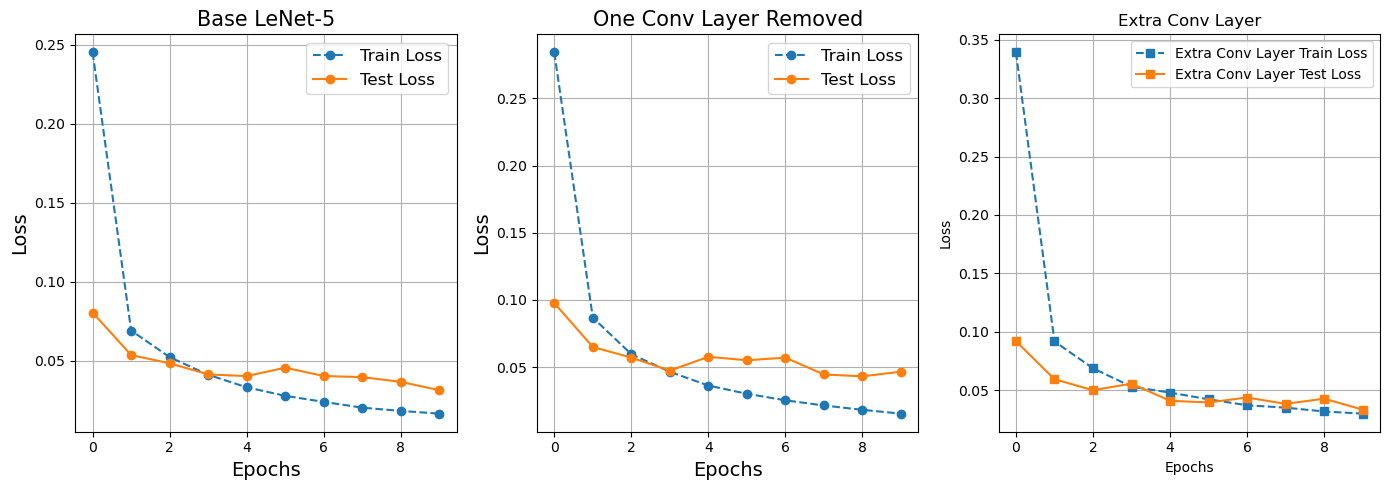

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(14, 5))  # Aquí, por ejemplo, 14 pulgadas de ancho y 10 de alto

# LeNet-5 (primer subgráfico)
axs[0].plot(train_loss_base, label='Train Loss', linestyle='--', marker='o')
axs[0].plot(test_loss_base, label='Test Loss', linestyle='-', marker='o')
axs[0].set_title('Base LeNet-5', fontsize=15)
axs[0].set_xlabel('Epochs', fontsize=14)
axs[0].set_ylabel('Loss', fontsize=14)
axs[0].legend(fontsize=12)
axs[0].grid(True)

# LeNet-5 con una capa conv removida (segundo subgráfico)
axs[1].plot(train_loss_oneconv, label='Train Loss', linestyle='--', marker='o')
axs[1].plot(test_loss_oneconv, label='Test Loss', linestyle='-', marker='o')
axs[1].set_title('One Conv Layer Removed', fontsize=15)
axs[1].set_xlabel('Epochs', fontsize=14)
axs[1].set_ylabel('Loss', fontsize=14)
axs[1].legend(fontsize=12)
axs[1].grid(True)

# LeNet-5 con una capa conv extra (tercer subgráfico)
axs[2].plot(train_loss_extraconv, label='Extra Conv Layer Train Loss', linestyle='--', marker='s')
axs[2].plot(test_loss_extraconv, label='Extra Conv Layer Test Loss', linestyle='-', marker='s')
axs[2].set_title('Extra Conv Layer')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Loss')
axs[2].legend()
axs[2].grid(True)

# Ajustar el diseño para evitar solapamientos
plt.tight_layout()
plt.show()